# Proyecto #3: Clustering - Inteligencia artificial

## Integrantes

- Pedro Domínguez
- Luis Chahua
- Carlos Guerrero

## Librerías

In [300]:
import pandas as pd
import numpy as np
import os

#Librerías que permitirá reducir dimensiones
import pywt
import pywt.data
from sklearn.decomposition import PCA

#Librerías para lectura/edición de imágenes
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

#Librerías para generar gráficas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tabulate import tabulate

#Librerías para realizar métricas
from sklearn.metrics.cluster import homogeneity_score

#Librerías para clustering
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram

## Lectura de datos

In [301]:
dataset_txt = "../data/dataset_tissue.txt"

dataset = pd.read_csv(dataset_txt).transpose()
dataset = dataset.drop(index = "Unnamed: 0", axis = 0).to_numpy()
#dataset.shape

types_txt = "../data/clase.txt"
true_labels = pd.read_csv(types_txt, index_col = 0).to_numpy().flatten()
#types.shape

In [302]:
#Showing the dataset and types dimension
dataset.shape, true_labels.shape

((189, 22215), (189,))

In [303]:
#Showing unique labels
unique_labels = np.unique(true_labels)
print(unique_labels)

# Encoding labels 
label_encoding = {label:i for i, label in enumerate(unique_labels)}
true_labels = [label_encoding[true_label] for true_label in true_labels]

['cerebellum' 'colon' 'endometrium' 'hippocampus' 'kidney' 'liver'
 'placenta']


## Initialization

### Wavelets families

In [304]:
discrete_family_wavelets = ['haar', 'bior', 'coif', 'rbio', 'sym', 'db', 'dmey']
discrete_wavelets = {family:pywt.wavelist(family) for family in discrete_family_wavelets}

### Number of clusters

In [305]:
n_clusters = list(range(2, 11))

### Dimensionality reduction

In [306]:
def reduce_thread_dimension(thread, wavelet = 'haar', cuts = 2):
  for i in range(cuts):
    (thread, cD) = pywt.dwt(thread, wavelet)
  return thread

def vectorize(matrix):
  return matrix.flatten()

def reduce_dataset_dimensionality(dataset, wavelet = 'haar', cuts = 2):
  
  temp = []
  #data_Y = []

  for features in dataset:
      
      #letter = features[0]
      #data_Y.append(letter)
      features = reduce_thread_dimension(features, wavelet, cuts)
      features = vectorize(features)
      temp.append(features)

  return np.array(temp) #data_Y

In [307]:
dataset = reduce_dataset_dimensionality(dataset, wavelet='haar')
dataset.shape

(189, 5554)

## K-mean implementation

In [308]:
def get_first_centroids(dataset, n_clusters):
    indexes = np.random.randint(len(dataset), size=n_clusters)

    centroids = np.zeros((n_clusters, len(dataset[0])))
    
    for i, index in enumerate(indexes):
        centroids[i] = dataset[index]
        
    return centroids

In [309]:
def get_centroid_label(thread, centroids):
    min_dist = float('inf')
    label = 0
    
    for i, centroid in enumerate(centroids):
        dist = np.linalg.norm(centroid - thread)

        if min_dist > dist:
            min_dist = dist
            label = i

    return label

In [310]:
def update_centroids(labels, dataset, n_clusters):
    temp = {label: np.array([]) for label in np.unique(labels)}

    for label in labels:
        temp[label] = np.append(temp[label], dataset[label])
    
    centroids = np.zeros((n_clusters, len(dataset[0])))

    for label, threads in temp.items():
         centroids[label] = np.mean(threads, axis=0)

    return centroids

In [311]:
def compare_centroids(centroids, next_centroids):
    for centroid, next_centroid in zip(centroids, next_centroids):
        close_enough = np.allclose(centroid, next_centroid)

        if not close_enough:
            return next_centroids, close_enough
    
    return next_centroids, close_enough

In [312]:
def kmeans(dataset, n_clusters = 7, iter = 100):
    labels = np.zeros(len(dataset), dtype=np.int8)
    centroids = get_first_centroids(dataset, n_clusters)
    close_enough = False

    #while not close_enough:
    for it in range(iter):
        for i, thread in enumerate(dataset):
            labels[i] = get_centroid_label(thread, centroids)

        next_centroids = update_centroids(labels, dataset, n_clusters)
        centroid, close_enough = compare_centroids(centroids, next_centroids)

        #print(close_enough)

    return labels

In [313]:
def get_score(dataset, true_labels):
    predicted_labels = kmeans(dataset)
    
    iterations = 10
    result = 0
    
    for i in range(iterations):
        result += homogeneity_score(true_labels, predicted_labels)

    return result / iterations

## Experimentation

#### Silhouette

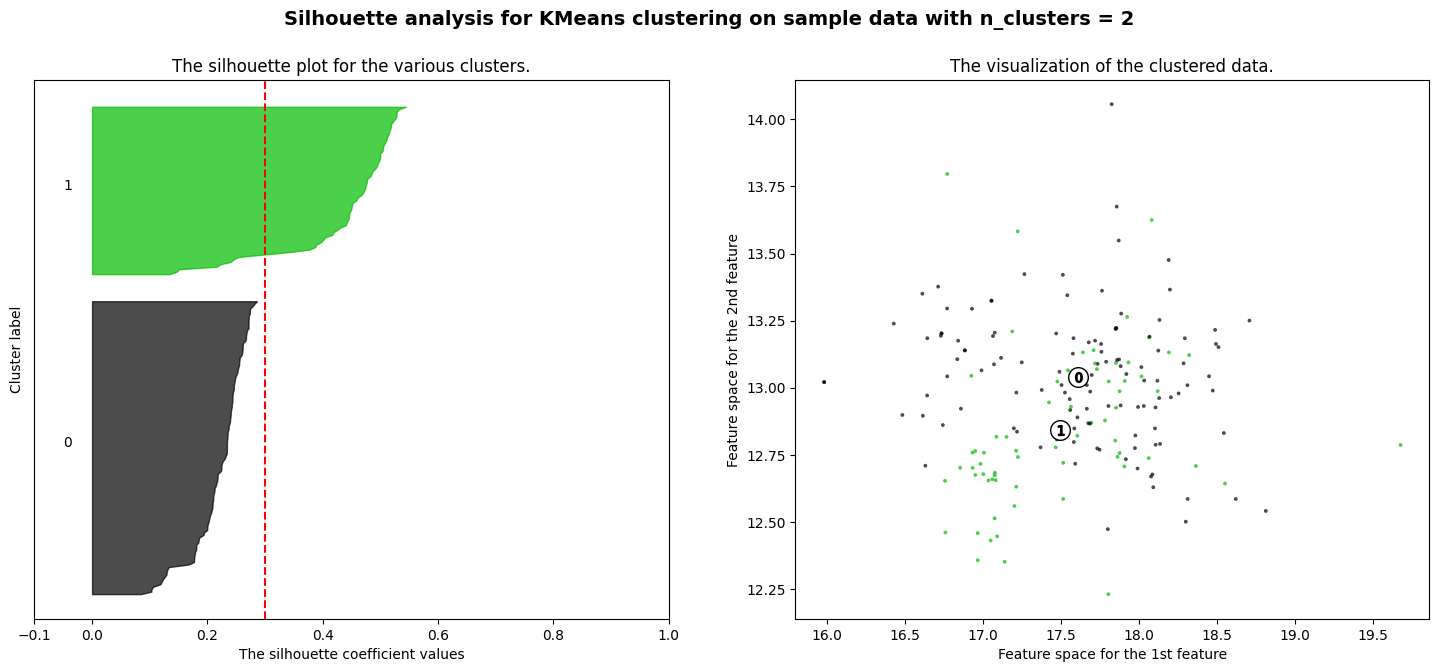

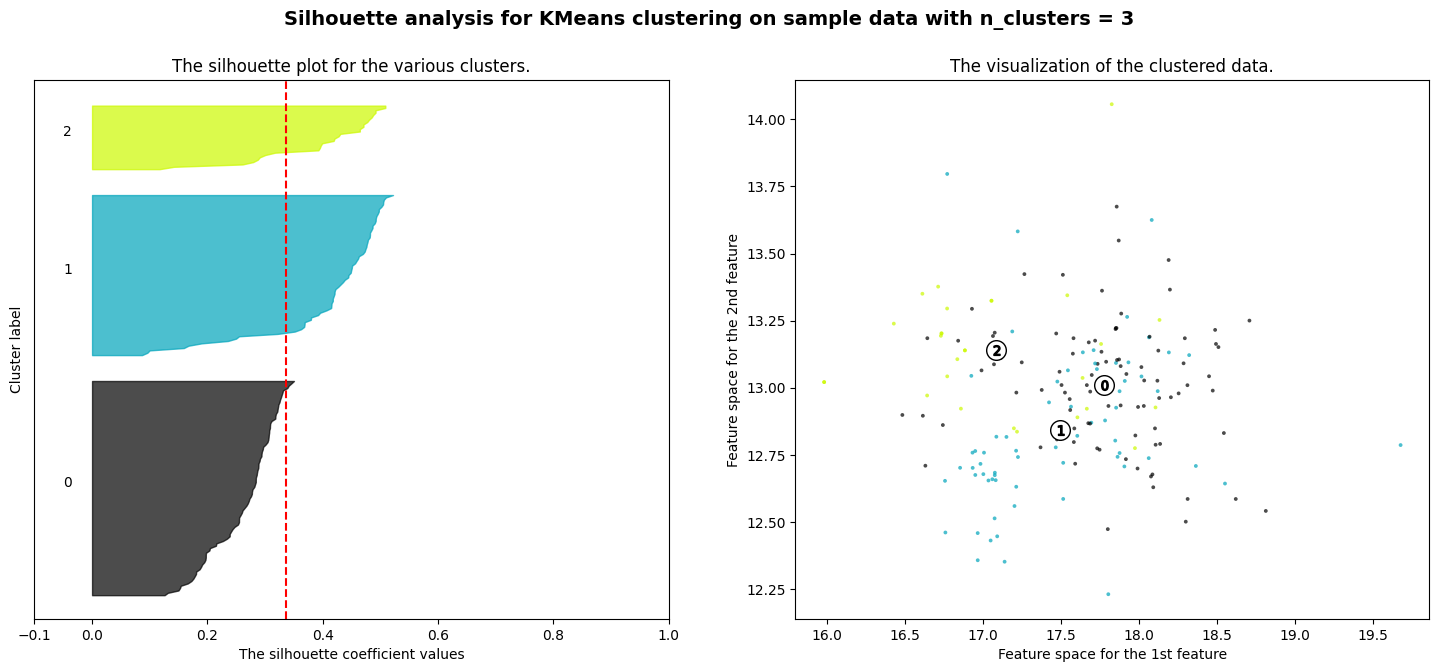

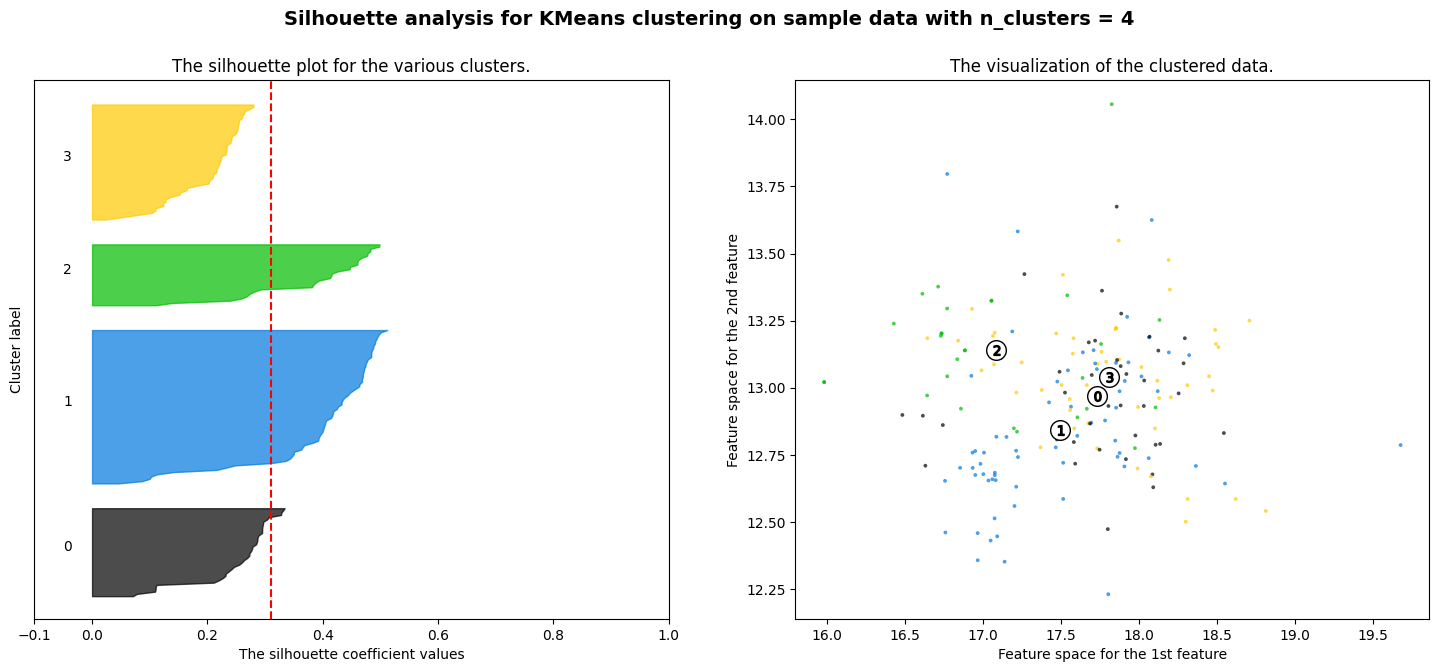

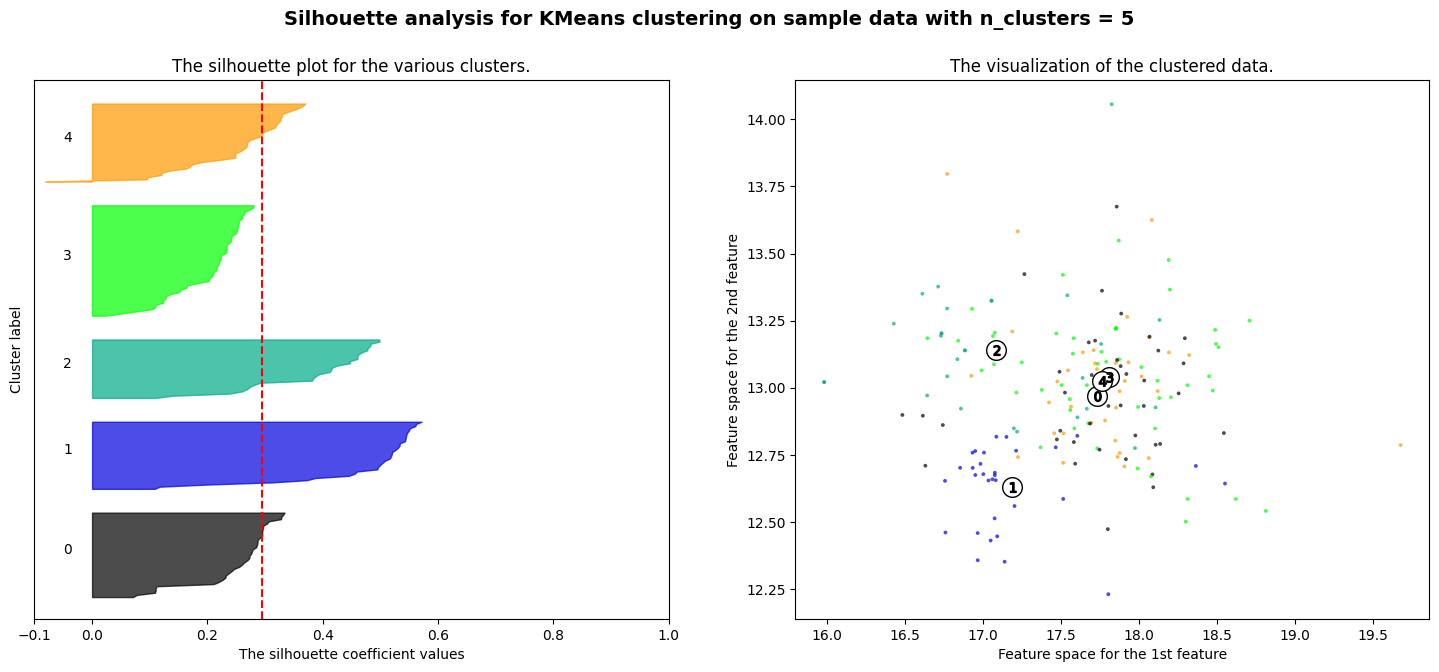

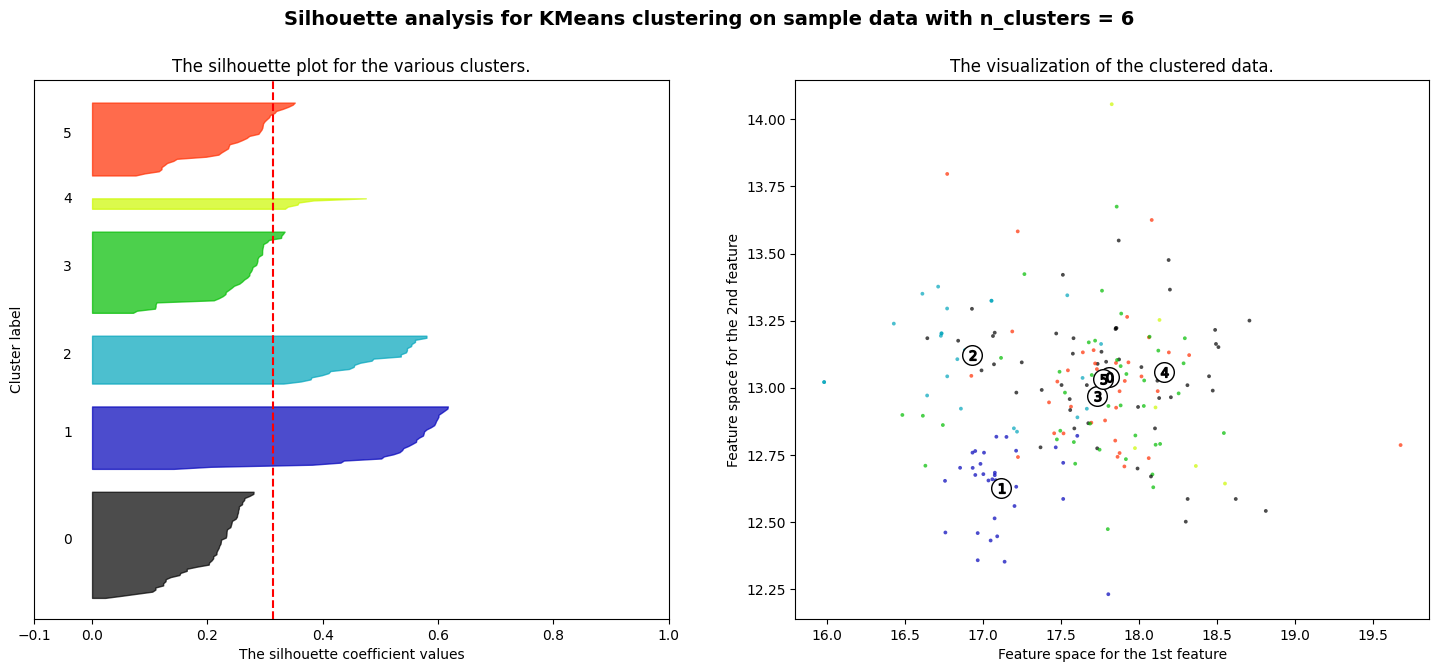

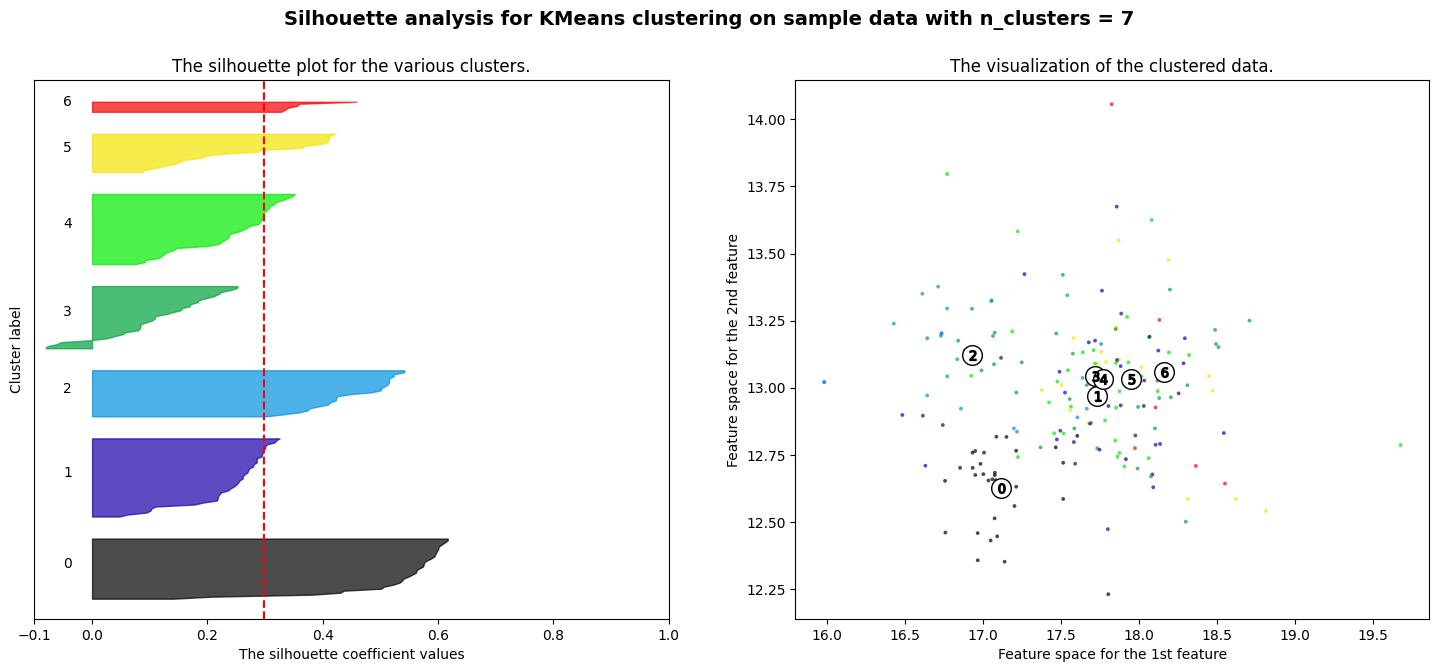

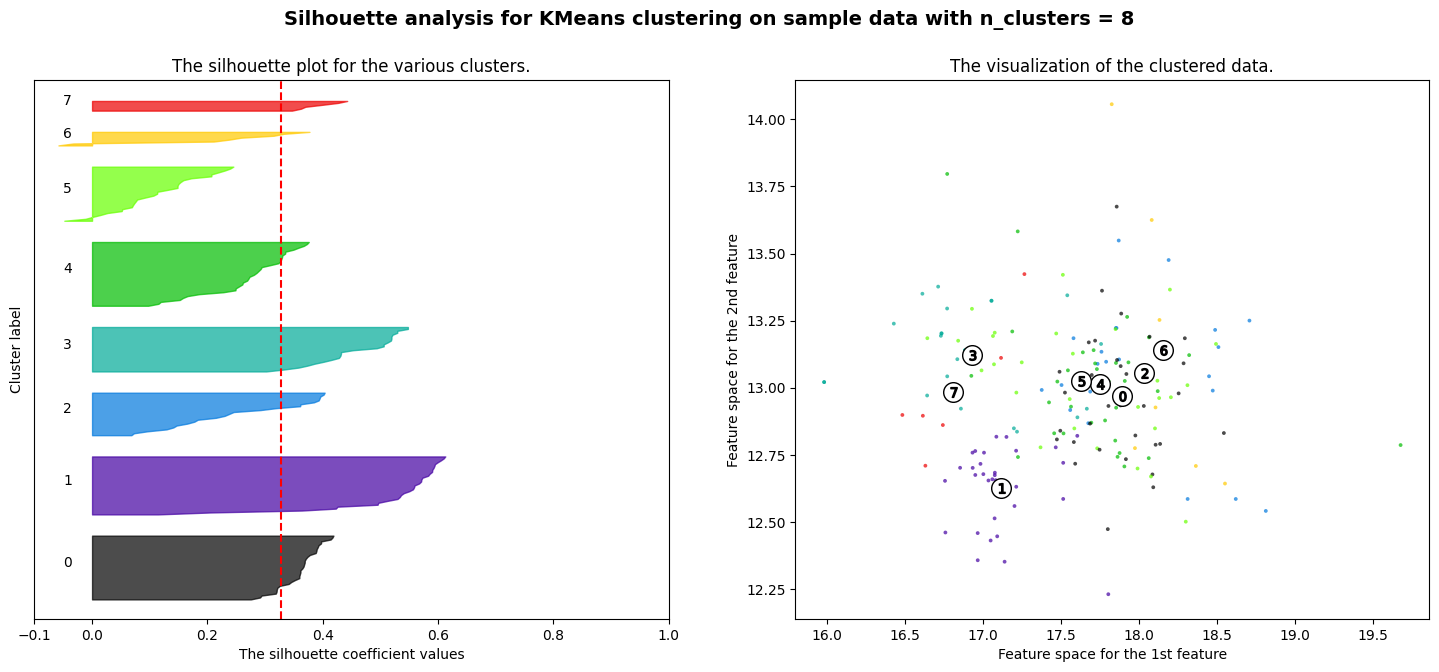

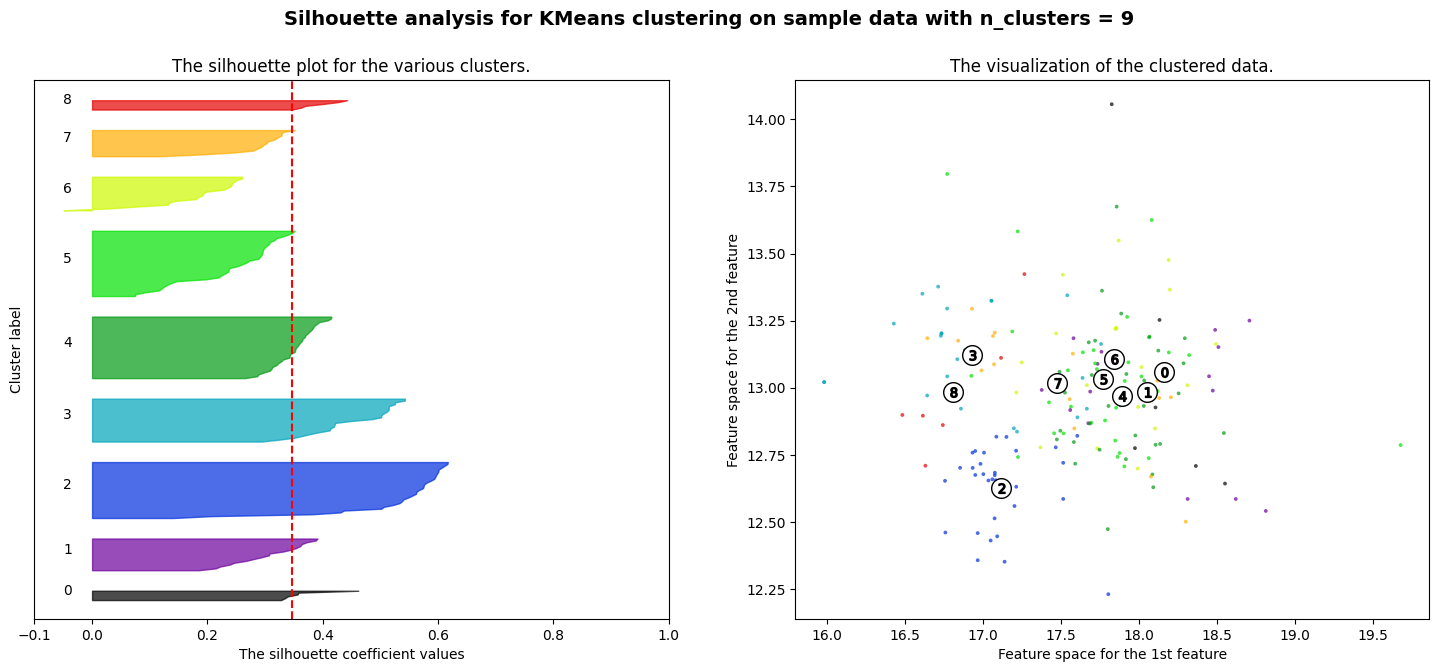

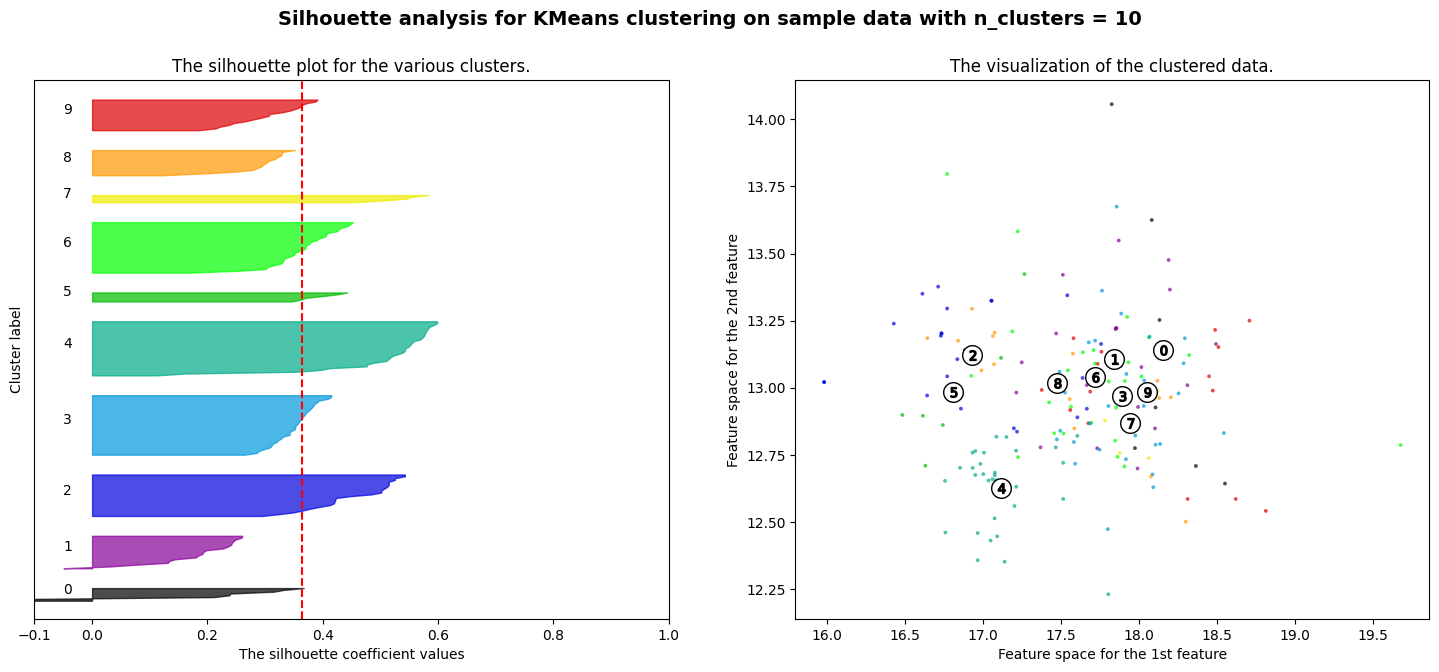

In [234]:
for n_cluster in n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(dataset) + (n_cluster + 1) * 10])

    clusterer = KMeans(n_clusters=n_cluster, random_state=10)
    cluster_labels = clusterer.fit_predict(dataset)
    silhouette_avg = silhouette_score(dataset, cluster_labels)

    sample_silhouette_values = silhouette_samples(dataset, cluster_labels)

    y_lower = 10

    for i in range(n_cluster):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_cluster)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_cluster)
    ax2.scatter(
        dataset[:, 0], dataset[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_cluster,
        fontsize=14,
        fontweight="bold",
    )
#dataset.name

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed

#### Scoring (Manual implementation)

In [318]:
get_score(dataset, true_labels)

0.9058070549053656

#### Scoring (Library)

In [319]:
clusterer = KMeans(n_clusters=7, random_state=7)
cluster_labels = clusterer.fit_predict(dataset)
homogeneity_score(true_labels, cluster_labels)

0.8905205793054277

#### Dendogram

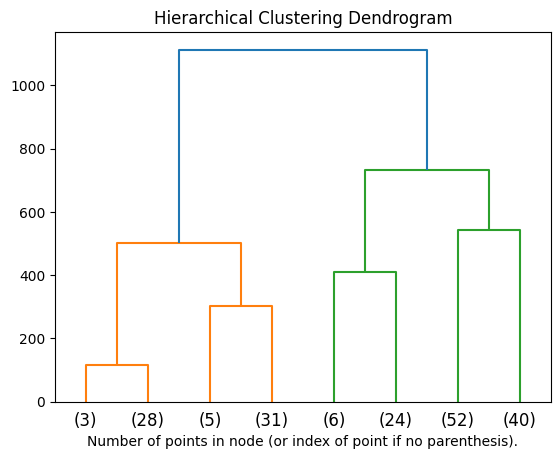

array([   0.        ,    0.        ,    0.        ,    0.        ,
         21.20608984,   22.52361433,   22.82727406,   26.12307125,
         28.12151307,   29.23032708,   29.47605491,   29.97854653,
         30.649163  ,   32.05722184,   32.51523013,   33.15552844,
         33.46052069,   33.47897669,   35.18031731,   35.97070199,
         36.45478363,   36.55835556,   36.9543585 ,   38.00841515,
         38.38298443,   39.07605616,   39.1208043 ,   39.22779266,
         39.36308584,   40.73812176,   40.75577502,   42.23022501,
         43.13314552,   43.13688123,   43.18088786,   43.42912495,
         43.97914458,   43.98252634,   45.16507055,   45.53557628,
         45.63044553,   45.73337456,   46.07658186,   46.58157916,
         46.88526999,   47.19101389,   47.455803  ,   47.46346846,
         48.17864208,   48.33887818,   48.37536988,   48.7965593 ,
         49.11168466,   49.36516764,   49.69963797,   49.90150191,
         50.40039438,   51.88633733,   52.61452738,   52.63915

In [215]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack( [model.children_, model.distances_, counts] ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram

plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
model.distances_